# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Infrastructure-for-multiple-realizations" data-toc-modified-id="Infrastructure-for-multiple-realizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Infrastructure for multiple realizations</a></div><div class="lev1 toc-item"><a href="#Optimization" data-toc-modified-id="Optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimization</a></div><div class="lev1 toc-item"><a href="#Visualizing-fitted-kernel" data-toc-modified-id="Visualizing-fitted-kernel-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualizing fitted kernel</a></div><div class="lev2 toc-item"><a href="#Empirical-variogram" data-toc-modified-id="Empirical-variogram-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Empirical variogram</a></div><div class="lev2 toc-item"><a href="#Variogram-plots" data-toc-modified-id="Variogram-plots-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Variogram plots</a></div><div class="lev1 toc-item"><a href="#Simulations-from-prior" data-toc-modified-id="Simulations-from-prior-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulations from prior</a></div><div class="lev2 toc-item"><a href="#Variogram-simulations" data-toc-modified-id="Variogram-simulations-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Variogram simulations</a></div><div class="lev1 toc-item"><a href="#Understanding-the-periodic-kernel" data-toc-modified-id="Understanding-the-periodic-kernel-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Understanding the periodic kernel</a></div><div class="lev1 toc-item"><a href="#Matern-Kernel" data-toc-modified-id="Matern-Kernel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Matern Kernel</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Fitting an entire year's data, even for just one station's data, is quite time consuming. We're not really interested in long-term correlations (like seasonal components), so it makes sense to divide the data up into smaller chunks (of a few weeks of data). Some information is lost, but I don't think any bias is introduced. If this means we can fit multiple stations' temperature time series, then this is a net win.

In [1]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, update_mll!, evaluate, metric
import GaussianProcesses: cov
import GaussianProcesses: optimize!, get_optim_target
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
using Optim
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
include("../src/preprocessing.jl")

test_data (generic function with 1 method)

In [4]:
data_dir=".."

".."

In [5]:
usaf=725450
wban=14990
id=1
station_data=read_station(usaf,wban,id; data_dir=data_dir)
add_ts_hours!(station_data)
station_data[1:5,:]

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] convert(::Type{Float64}, ::Base.Dates.Millisecond) at ./deprecated.jl:57
 [3] copy!(::IndexLinear, ::Array{Float64,1}, ::IndexLinear, ::Array{Base.Dates.Millisecond,1}) at ./abstractarray.jl:655
 [4] convert(::Type{Array{Float64,1}}, ::Array{Base.Dates.Millisecond,1}) at ./array.jl:340
 [5] add_ts_hours!(::DataTables.DataTable) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:44
 [6] include_string(::String, ::String) at ./loading.jl:515
 [7] include_string(::Module, ::String, ::String) at /Users/imolk/Library/Julia/packages/v0.6/Compat/src/Compat.jl:464
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/Library/Julia/packages/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/imolk/Library/Julia/packages/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[5], in expression starting on line 5


,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1,0.0
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1,1.0
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1,2.0
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1,3.0
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1,4.0


# Kernel Specification

In [6]:
k0 = Noise(-1.0)
k1 = fix(Periodic(log(0.5), log(√(10.0)), log(24.0)), :lp)
k2 = RQIso(log(2.0), log(√10.0), 3.0) # short term
k3 = SEIso(log(2.0), log(√10.0)) # short term SE
k4 = RQIso(log(1.0*24), log(√10.0), 3.0)
k5 = RQIso(log(10.0*24), log(√10.0), 3.0)
k6 = SE(log(100.0*24), log(√80.0))
_k=k0+k1+k2+k3+k4+k5
_k_nonoise=k1+k2+k3+k4+k5+k6
_logNoise=log(k0.σ2)/2.0
hyp=[-0.359207,0.36883,1.45171,2.0342,1.17682,2.88579,4.28659,1.49533,-0.16544,6.81425,1.3045,3.49925,7.34764,2.16028]
hyp_nonoise=[-1.49471,9.68156,0.28408,1.04675,-1.18377,-0.886588,-0.0974043,2.6959,2.41763,-3.61659,6.89384,1.18493,3.49553,7.7369,2.4648]
# set_params!(_k, hyp)
# set_params!(_k_nonoise, hyp_nonoise[3:end])
_logNoise=hyp_nonoise[1]
_meanfunc=MeanConst(0.0)
;

# Infrastructure for multiple realizations

In [7]:
include("../src/GPrealisations.jl")

optimize_NLopt (generic function with 1 method)

In [8]:
ts_vec = convert(Vector{Float64}, station_data[:ts_hours])
ts_arr = reshape(ts_vec, (1,length(ts_vec)));
temp_vec = convert(Vector{Float64}, station_data[:temp])
;

In [9]:
chunksize=300
istart=1
gprealisations=GPE[]
while istart+chunksize < length(ts_arr)
    x = ts_arr[istart:istart+chunksize-1]
    y = temp_vec[istart:istart+chunksize-1]
    m = MeanConst(mean(y))
    gp = GPE(x, y, m, _k_nonoise, _logNoise);
    push!(gprealisations, gp)
    istart+=chunksize
end

In [10]:
_gpr = GPRealisations(gprealisations, _meanfunc, _k_nonoise, _logNoise, 0.0, Float64[]);
update_mll!(_gpr)
_gpr.mll

-17204.742630452056

In [11]:
update_mll_and_dmll!(_gpr, mean=false)
@time update_mll_and_dmll!(_gpr, mean=false);
_gpr.dmll

  1.559776 seconds (4.33 k allocations: 27.273 MiB, 8.04% gc time)


16-element Array{Float64,1}:
  7809.38     
   185.02     
  -227.158    
  -518.047    
 -1228.11     
  -139.788    
  1061.26     
 -1455.59     
     3.42307  
    53.1789   
     0.399457 
    -8.99274  
     6.24337  
     0.0253696
    -0.915614 
   -30.4903   

In [12]:
_func = get_optim_target(_gpr, mean=false)

NLSolversBase.OnceDifferentiable{Float64,Array{Float64,1}}(mll, NLSolversBase.#2, NLSolversBase.#2, 17204.742630452056, [-7809.38, -185.02, 227.158, 518.047, 1228.11, 139.788, -1061.26, 1455.59, -3.42307, -53.1789, -0.399457, 8.99274, -6.24337, -0.0253696, 0.915614, 30.4903], [-1.49471, -0.693147, 1.15129, 0.693147, 1.15129, 3.0, 0.693147, 1.15129, 3.17805, 1.15129, 3.0, 5.48064, 1.15129, 3.0, 7.78322, 2.19101], [-1.49471, -0.693147, 1.15129, 0.693147, 1.15129, 3.0, 0.693147, 1.15129, 3.17805, 1.15129, 3.0, 5.48064, 1.15129, 3.0, 7.78322, 2.19101], [1], [1])

In [13]:
import Calculus

In [14]:
_x=get_params(_gpr, mean=false)
numgrad = Calculus.gradient(_func.f, _x)

16-element Array{Float64,1}:
 -7809.38     
  -185.02     
   227.158    
   518.047    
  1228.11     
   139.788    
 -1061.26     
  1455.59     
    -3.42303  
   -53.1789   
    -0.399516 
     8.99273  
    -6.24339  
    -0.0252639
     0.915614 
    30.4903   

In [15]:
anlgrad=similar(numgrad) # analytical gradient
_func.g!(anlgrad, _x)

17204.742630452056

In [16]:
for (i,j) in zip(numgrad,anlgrad)
    @printf("%10.3f %10.3f\n", i, j)
    @assert isapprox(i,j, rtol=1e-4, atol=1e-3)
end

 -7809.376  -7809.375
  -185.020   -185.020
   227.158    227.158
   518.047    518.047
  1228.110   1228.110
   139.788    139.788
 -1061.258  -1061.258
  1455.591   1455.590
    -3.423     -3.423
   -53.179    -53.179
    -0.400     -0.399
     8.993      8.993
    -6.243     -6.243
    -0.025     -0.025
     0.916      0.916
    30.490     30.490


# Optimization

In [17]:
@time opt_out=optimize!(_gpr, mean=false, options=Optim.Options(x_tol=1e-5, f_tol=1e-10));

1357.591277 seconds (4.70 M allocations: 35.227 GiB, 0.38% gc time)


In [18]:
opt_out

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.49471,-0.6931471805599453, ...]
 * Minimizer: [-1.4695384853928064,-0.06926626493766218, ...]
 * Minimum: 1.245408e+04
 * Iterations: 678
 * Convergence: true
   * |x - x'| < 1.0e-05: false 
     |x - x'| = 1.19e-04 
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: true
     |f(x) - f(x')| / |f(x)| = 9.04e-11 
   * |g(x)| < 1.0e-08: false 
     |g(x)| = 3.43e-02 
   * stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 1389
 * Gradient Calls: 712

In [19]:
print(Optim.minimizer(opt_out))

[-1.46954, -0.0692663, 1.0608, 1.66372, 1.27221, -1.79776, -1.24964, -1.05922, 3.1442, 1.32078, 6.20616, 3.16221, -0.427863, 3.79454, 7.68138, -7.96554]

In [20]:
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.kern.σ2)
@printf("l: %5.3f\n", √k1.kern.ℓ2)
@printf("p: %5.0f hours\n", k1.kern.p)
print("\nk₂: RQIso \n=================\n")
@printf("σ: %5.3f\n", √ k2.σ2)
@printf("l: %5.3f hours\n", √ k2.ℓ2)
@printf("α: %5.3f\n", k2.α)
print("\nk₃: SEIso \n=================\n")
@printf("σ: %5.3f\n", √k3.σ2)
@printf("l: %5.3f hours\n", √k3.ℓ2)
print("\nk₄: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k4.σ2)
@printf("l: %5.3f days\n", √k4.ℓ2 / 24)
@printf("α: %5.3f\n",  k4.α)
print("\nk₅: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k5.σ2)
@printf("l: %5.3f days\n", √k5.ℓ2 / 24)
@printf("α: %5.3f\n",  k5.α)
print("\nk₆ SEIso \n=================\n")
@printf("σ: %5.3f\n", √k6.σ2)
@printf("l: %5.3f days\n", √k6.ℓ2 / 24)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(_gpr.logNoise))

k₁: Periodic 
σ: 2.889
l: 0.933
p:    24 hours

k₂: RQIso 
σ: 3.569
l: 5.279 hours
α: 0.166

k₃: SEIso 
σ: 0.347
l: 0.287 hours

k₄: RQIso 
σ: 3.746
l: 0.967 days
α: 495.795

k₅: RQIso 
σ: 0.652
l: 0.984 days
α: 44.458

k₆ SEIso 
σ: 0.000
l: 90.317 days

σy: 0.230


# Visualizing fitted kernel

## Empirical variogram

In [21]:
function variogram(times, values, bins)
    npairs = zeros(Int, length(bins))
    sqdiff_accum = zeros(Float64, length(bins))
    n = length(times)
    for (i, t1) in enumerate(times)
        ibin = 1
        for j in i:n
            Δt = times[j] - t1
            while Δt>bins[ibin]
                ibin += 1
            end
            npairs[ibin] += 1
            sqdiff_accum[ibin] += (values[j]-values[i])^2
        end
    end
    return sqdiff_accum ./ (npairs.*2)
end

_bins = collect(0:400*24)
station_variog = variogram(ts_vec, temp_vec.-mean(temp_vec), _bins)
;

## Variogram plots

In [22]:
# Assume all components are stationary
function cov(sumkern::SumKernel, r::Float64)
    ck = 0.0
    for k in sumkern.kerns
        ck += cov(k, [r], [0.0])
    end
    return ck
end
;

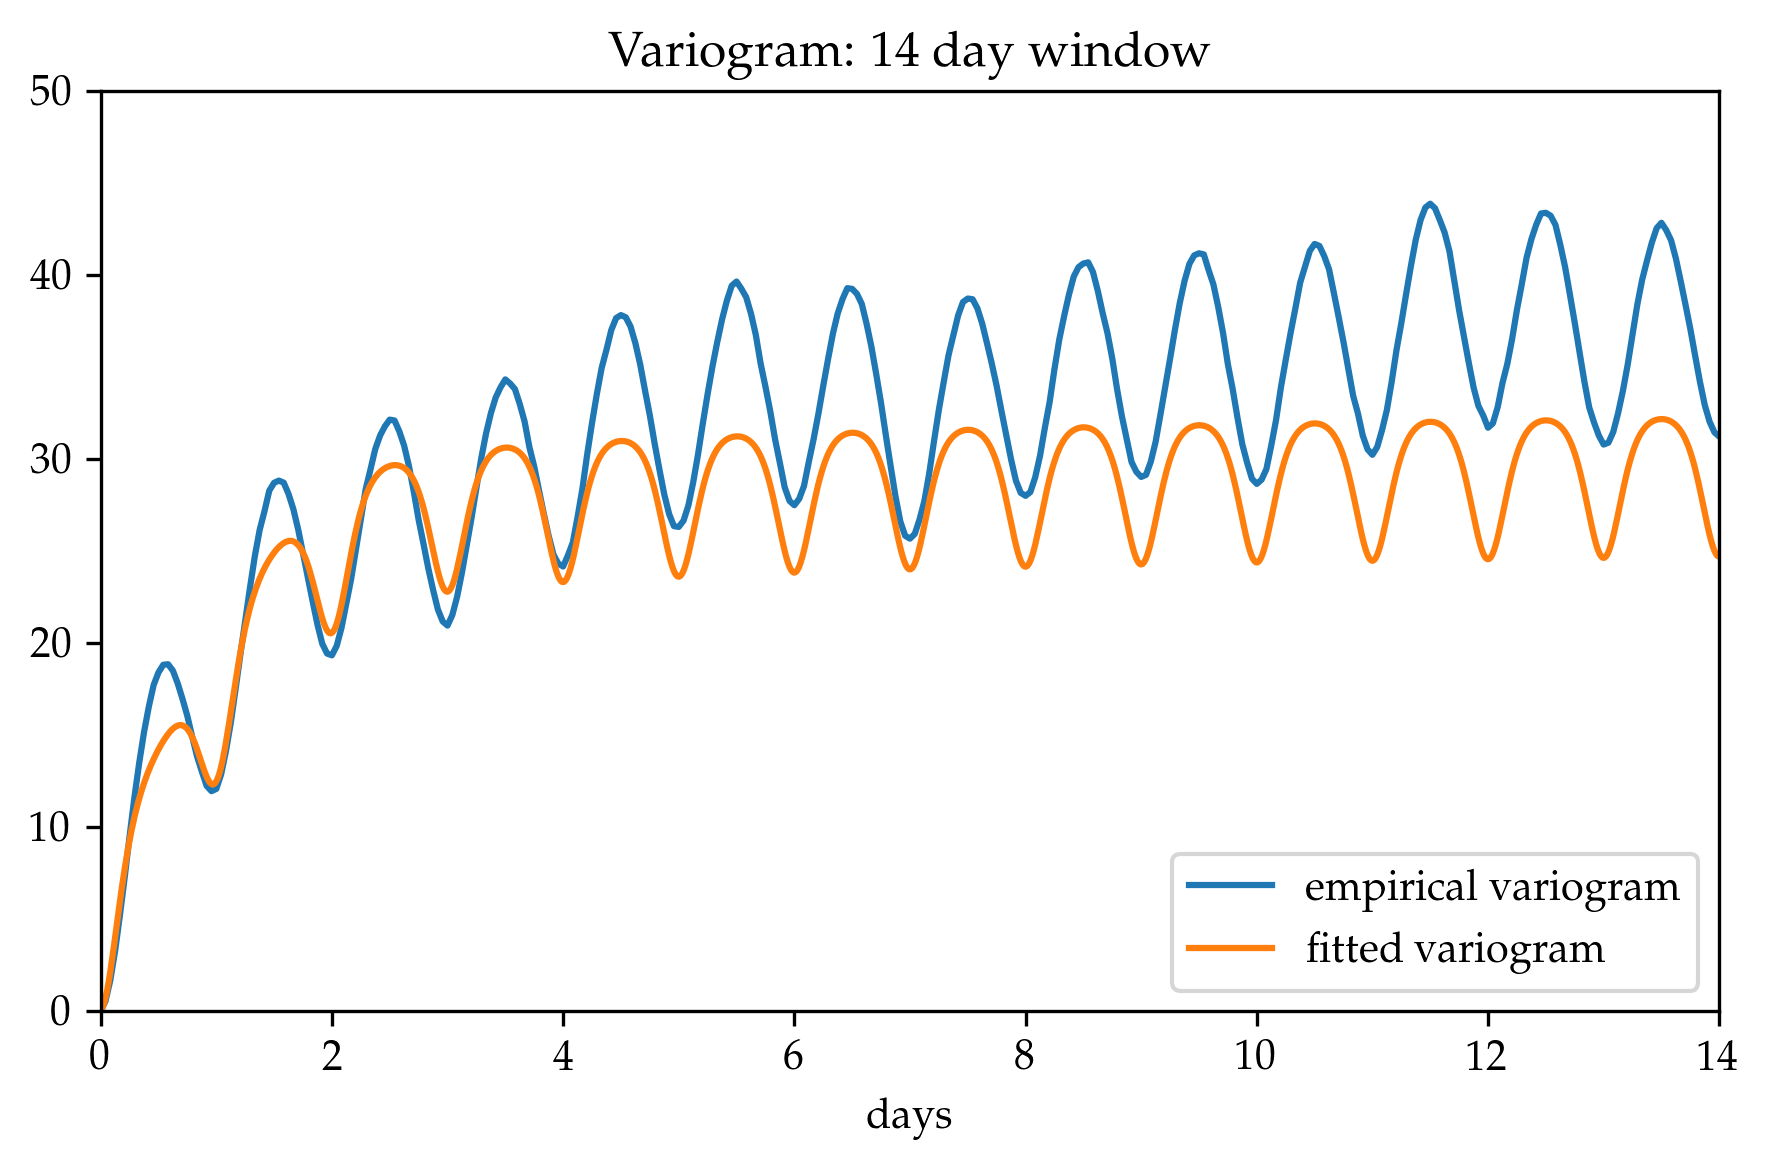

In [23]:
begin
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, label="empirical variogram")
    plt.ylim(0,50)
    plt.xlim(0,14)
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24.0, exp(2.0*_gpr.logNoise)+ck_r[1].-ck_r, label="fitted variogram")
    plt.legend(loc="lower right")
    plt.xlabel("days")
    plt.title("Variogram: 14 day window")
end
;

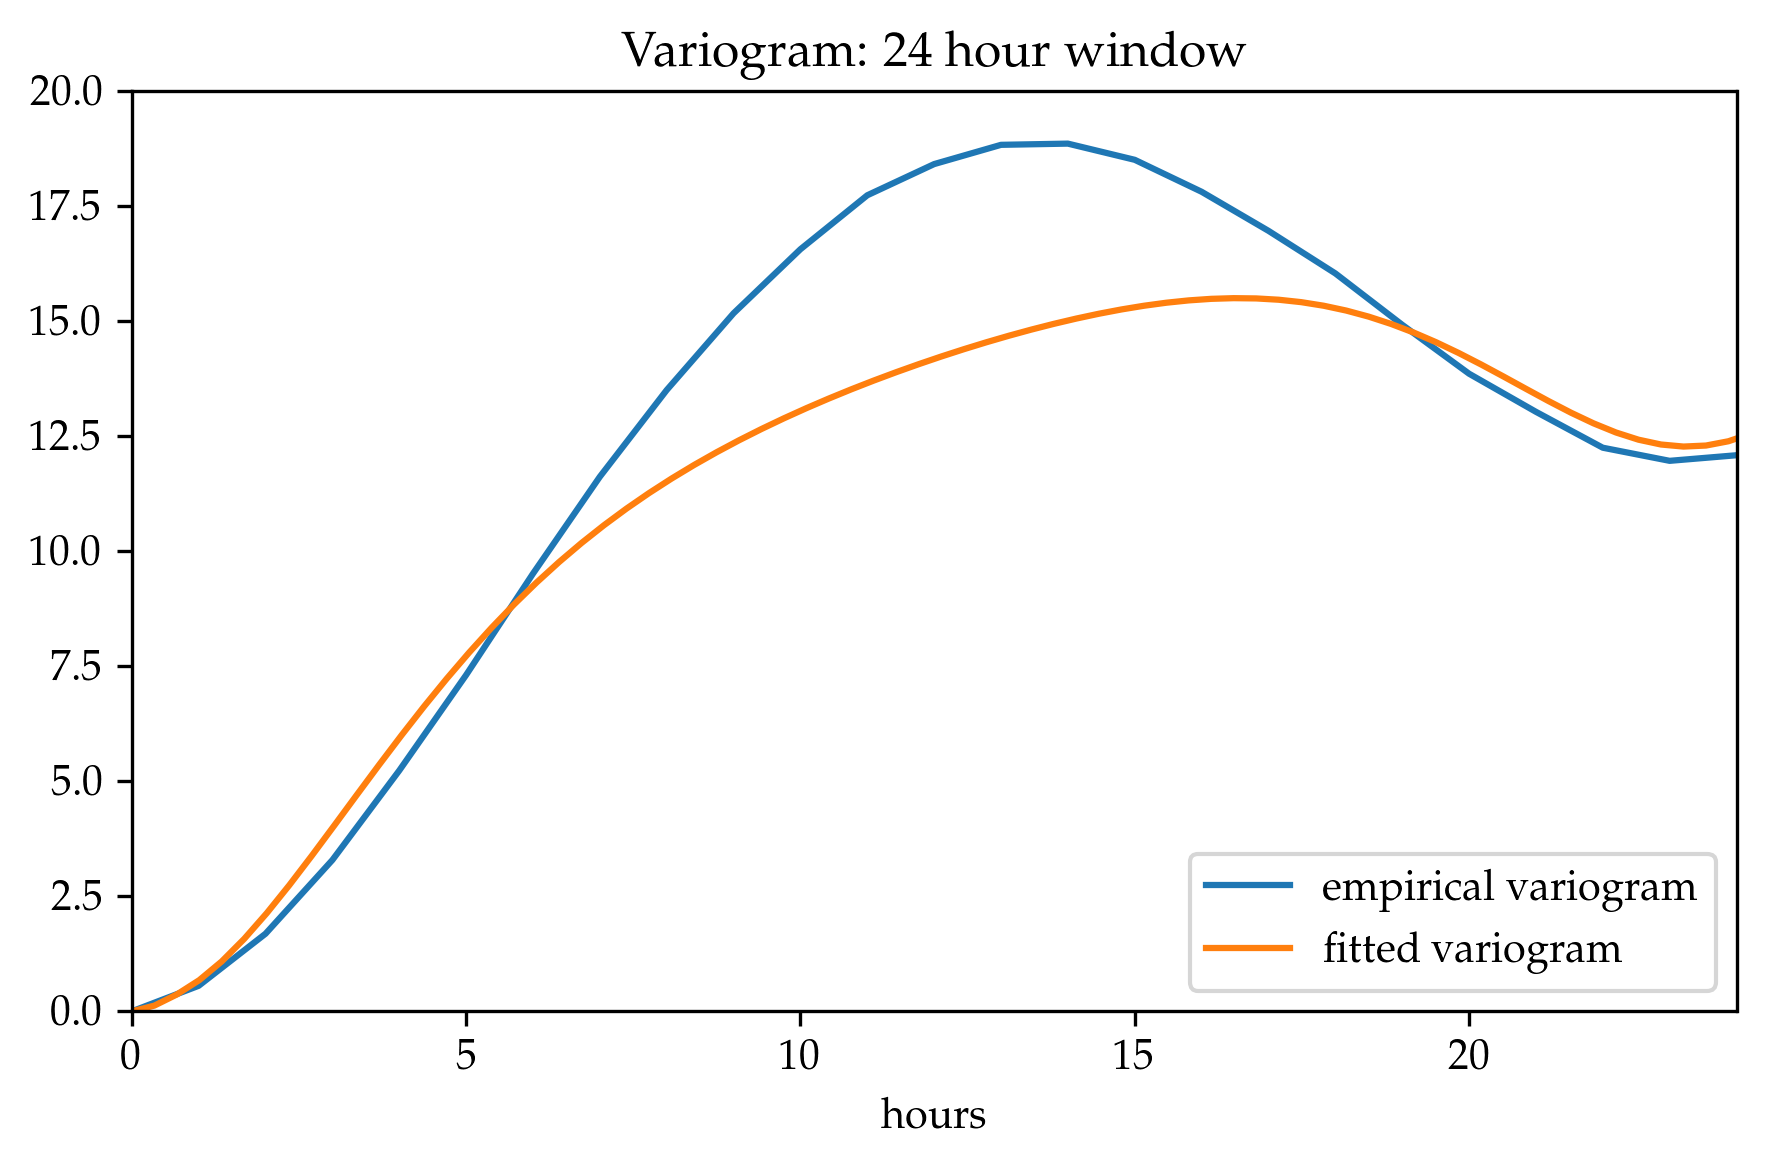

In [24]:
begin
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_hours, station_variog, label="empirical variogram")
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr, ck_r[1].-ck_r, label="fitted variogram")
    plt.legend(loc="lower right")
    plt.xlabel("hours")
    plt.ylim(0,20)
    plt.xlim(0,24)
    plt.title("Variogram: 24 hour window")
end
;

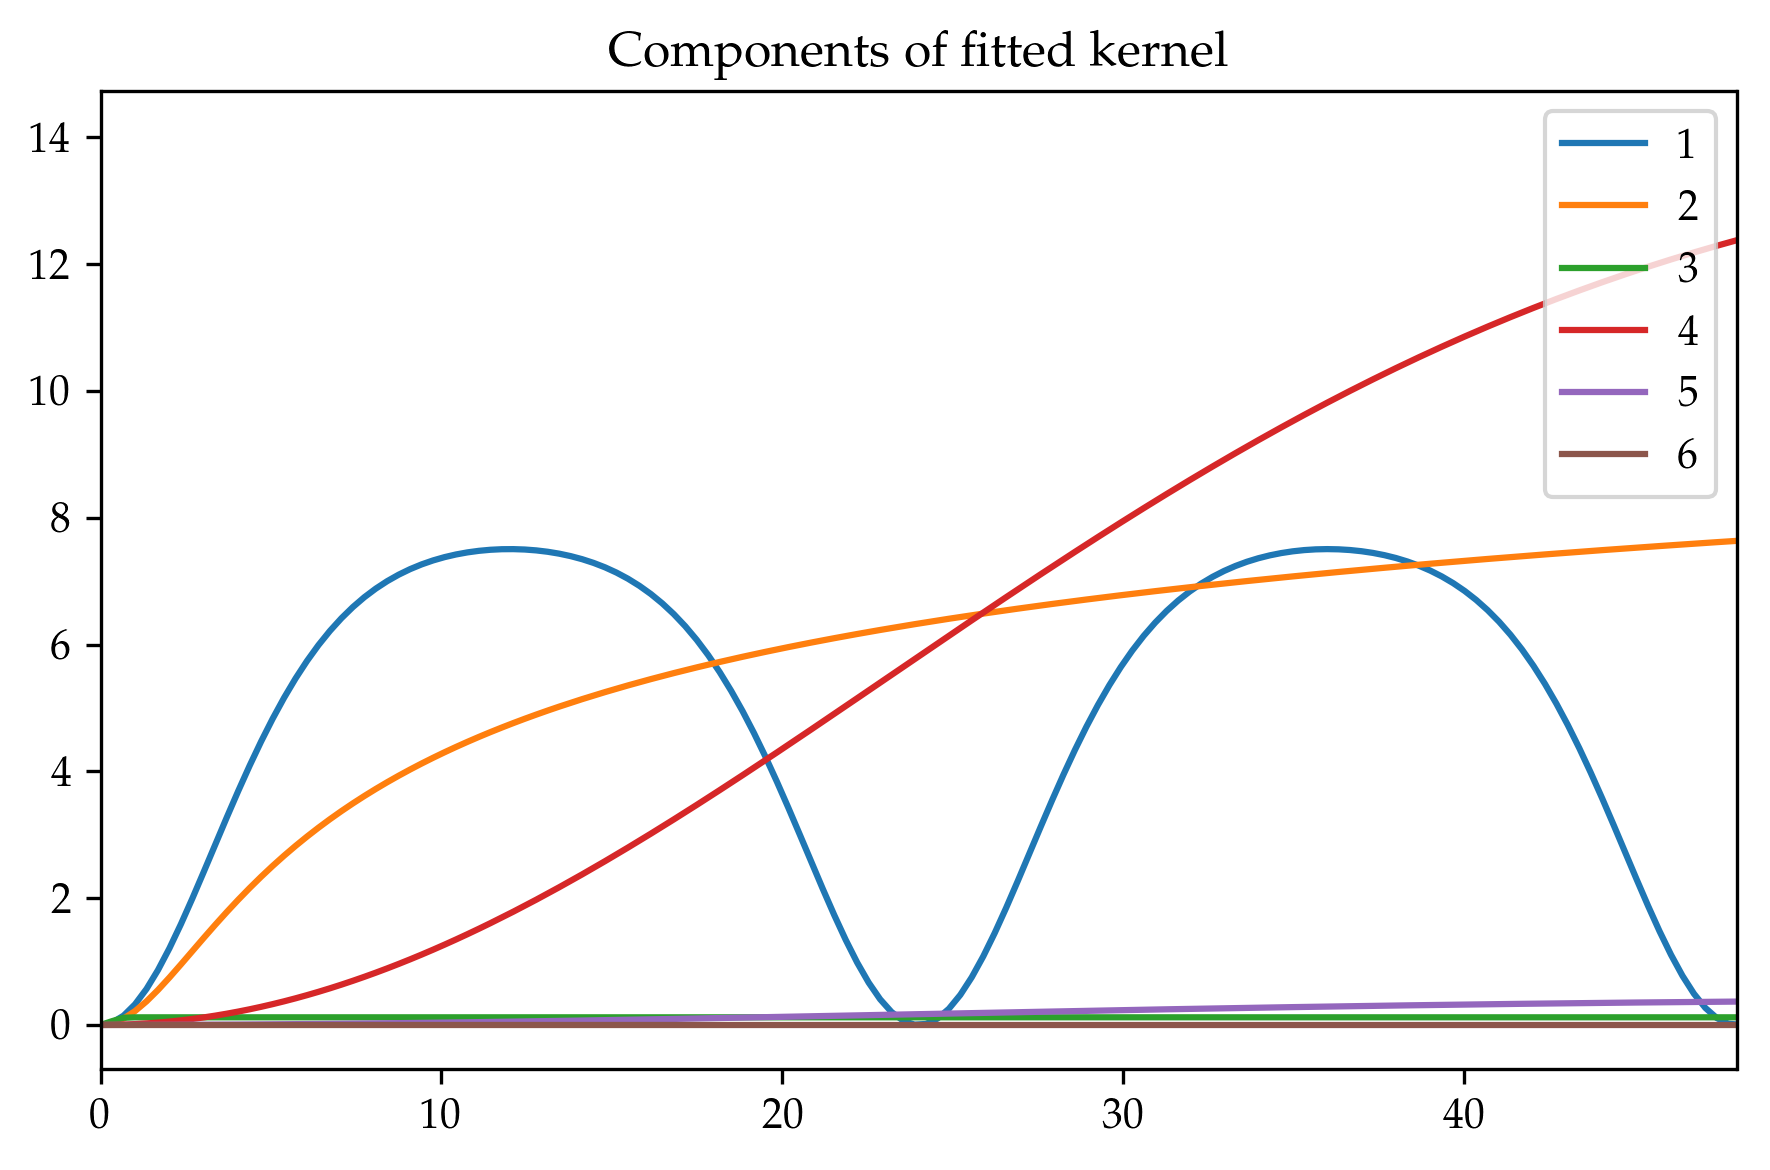

In [25]:
begin
    rr = linspace(0.0, 24*14, 1000)
    for (i,k) in enumerate(_k_nonoise.kerns)
        cki_r = [cov(k, [r], [0.0]) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, label=string(i));
    end
    plt.xlim(0,24*2)
    plt.legend(loc="upper right")
    plt.title("Components of fitted kernel")
end
;

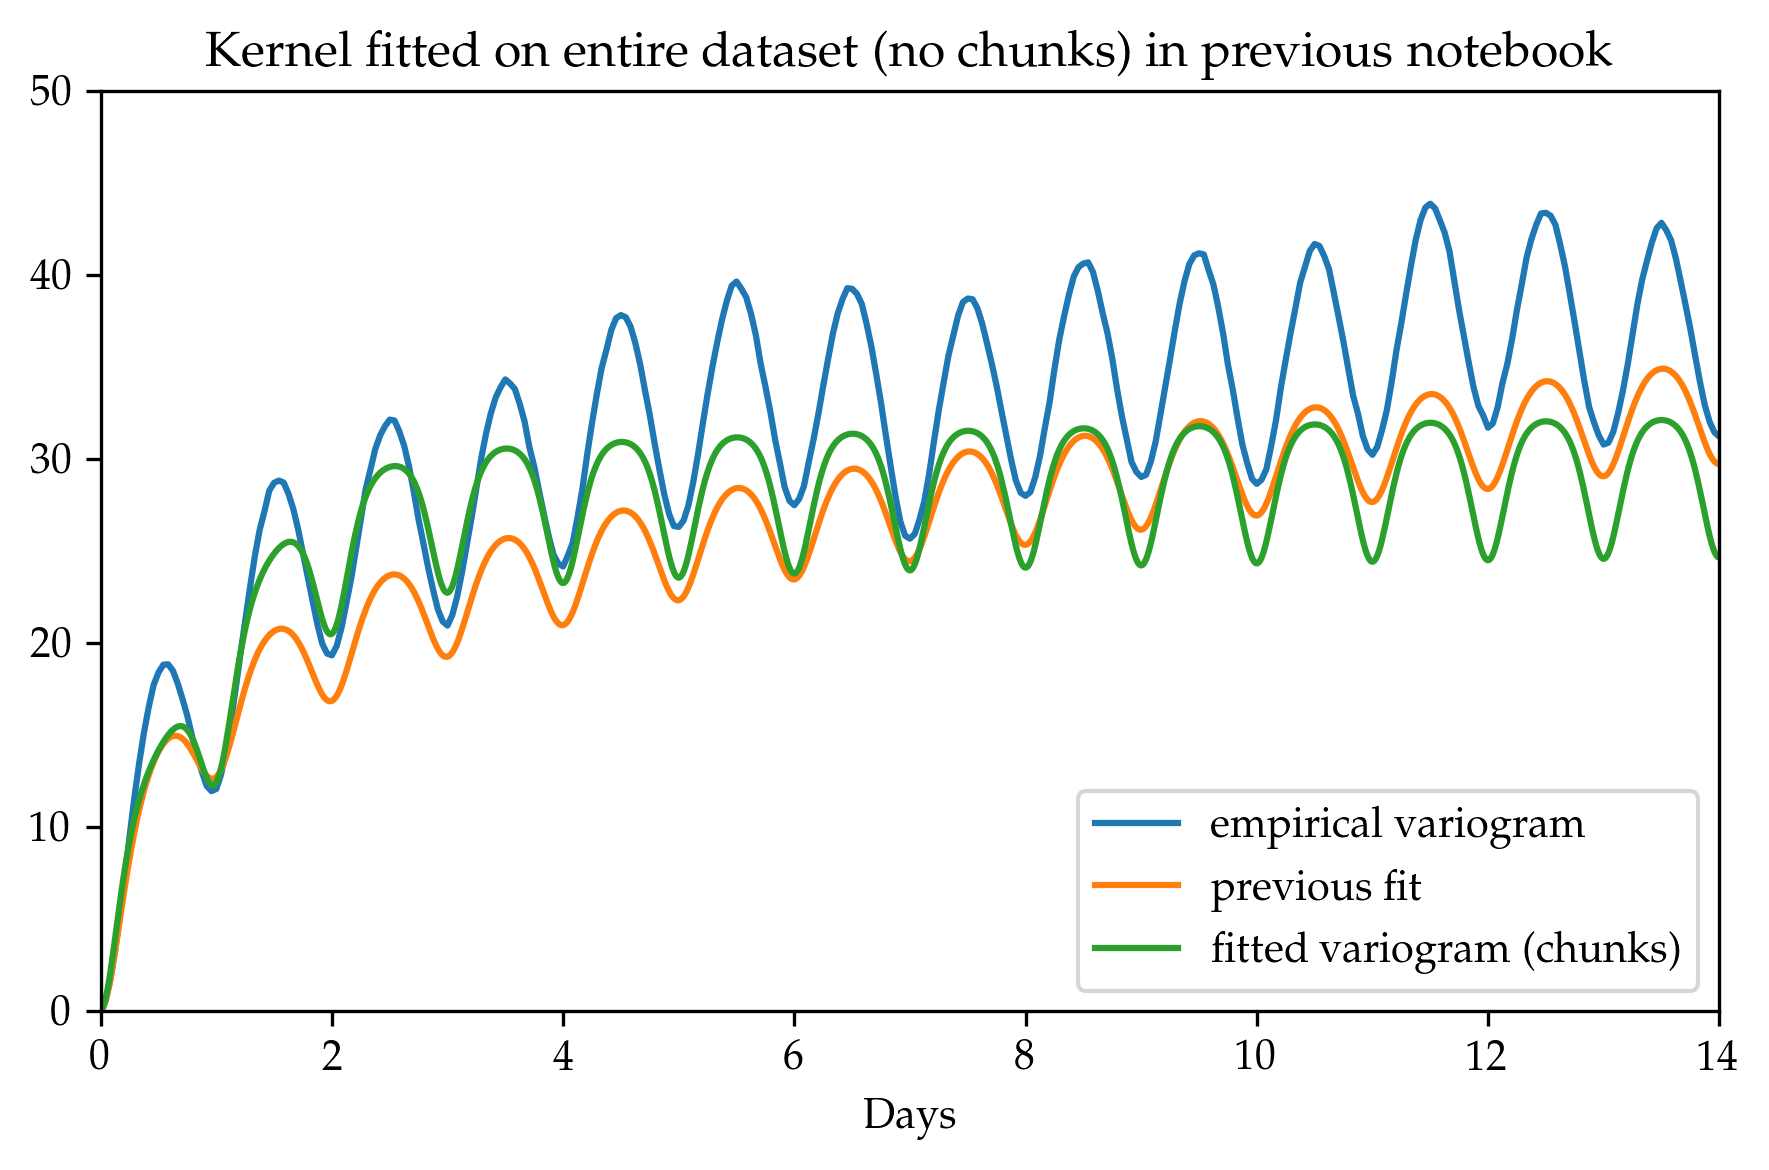

In [26]:
begin
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, label="empirical variogram")
    __k0 = Noise(0.0)
    __k1 = fix(Periodic(log(0.5), log(√(10.0)), log(24.0)), :lp)
    __k2 = RQIso(log(0.1*24), log(√10.0), 3.0) # short term
    __k3 = RQIso(log(3.0*24), log(√20.0), 3.0)
    __k4 = RQIso(log(10.0*24), log(√20.0), 3.0)
    __k5 = SE(log(200.0*24), log(√80.0))
    __k_nonoise=__k1+__k2+__k3+__k4+__k5
    set_params!(__k_nonoise, hyp_nonoise[3:end] )
    rr = linspace(0.0, 24*14, 1000)
    _ck_r = [cov(__k_nonoise, r) for r in rr]
    plt.plot(rr/24, _ck_r[1]-_ck_r, label="previous fit")
    
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24, ck_r[1].-ck_r, label="fitted variogram (chunks)")
    
    plt.xlim(0,14)
    plt.ylim(0,50)
    plt.xlabel("Days")
    plt.legend(loc="lower right")
    plt.title("Kernel fitted on entire dataset (no chunks) in previous notebook")
end
;

Looking at the variograms, the fit is pretty close, though I had hoped for an even closer match, given the flexibility of the kernel. In particular, the amplitude of the periodic component clearly looks too small. It's possible that the model is trading off fitting short-term correlations very well, at the expense of the diurnal and longer components.

# Simulations from prior

It's worth also simulating a few time series from the prior with the kernel hyperparameters as fitted above. Visually comparing this to the real data, we can check that they look similar, in terms of amplitude and timescales of temperature changes.

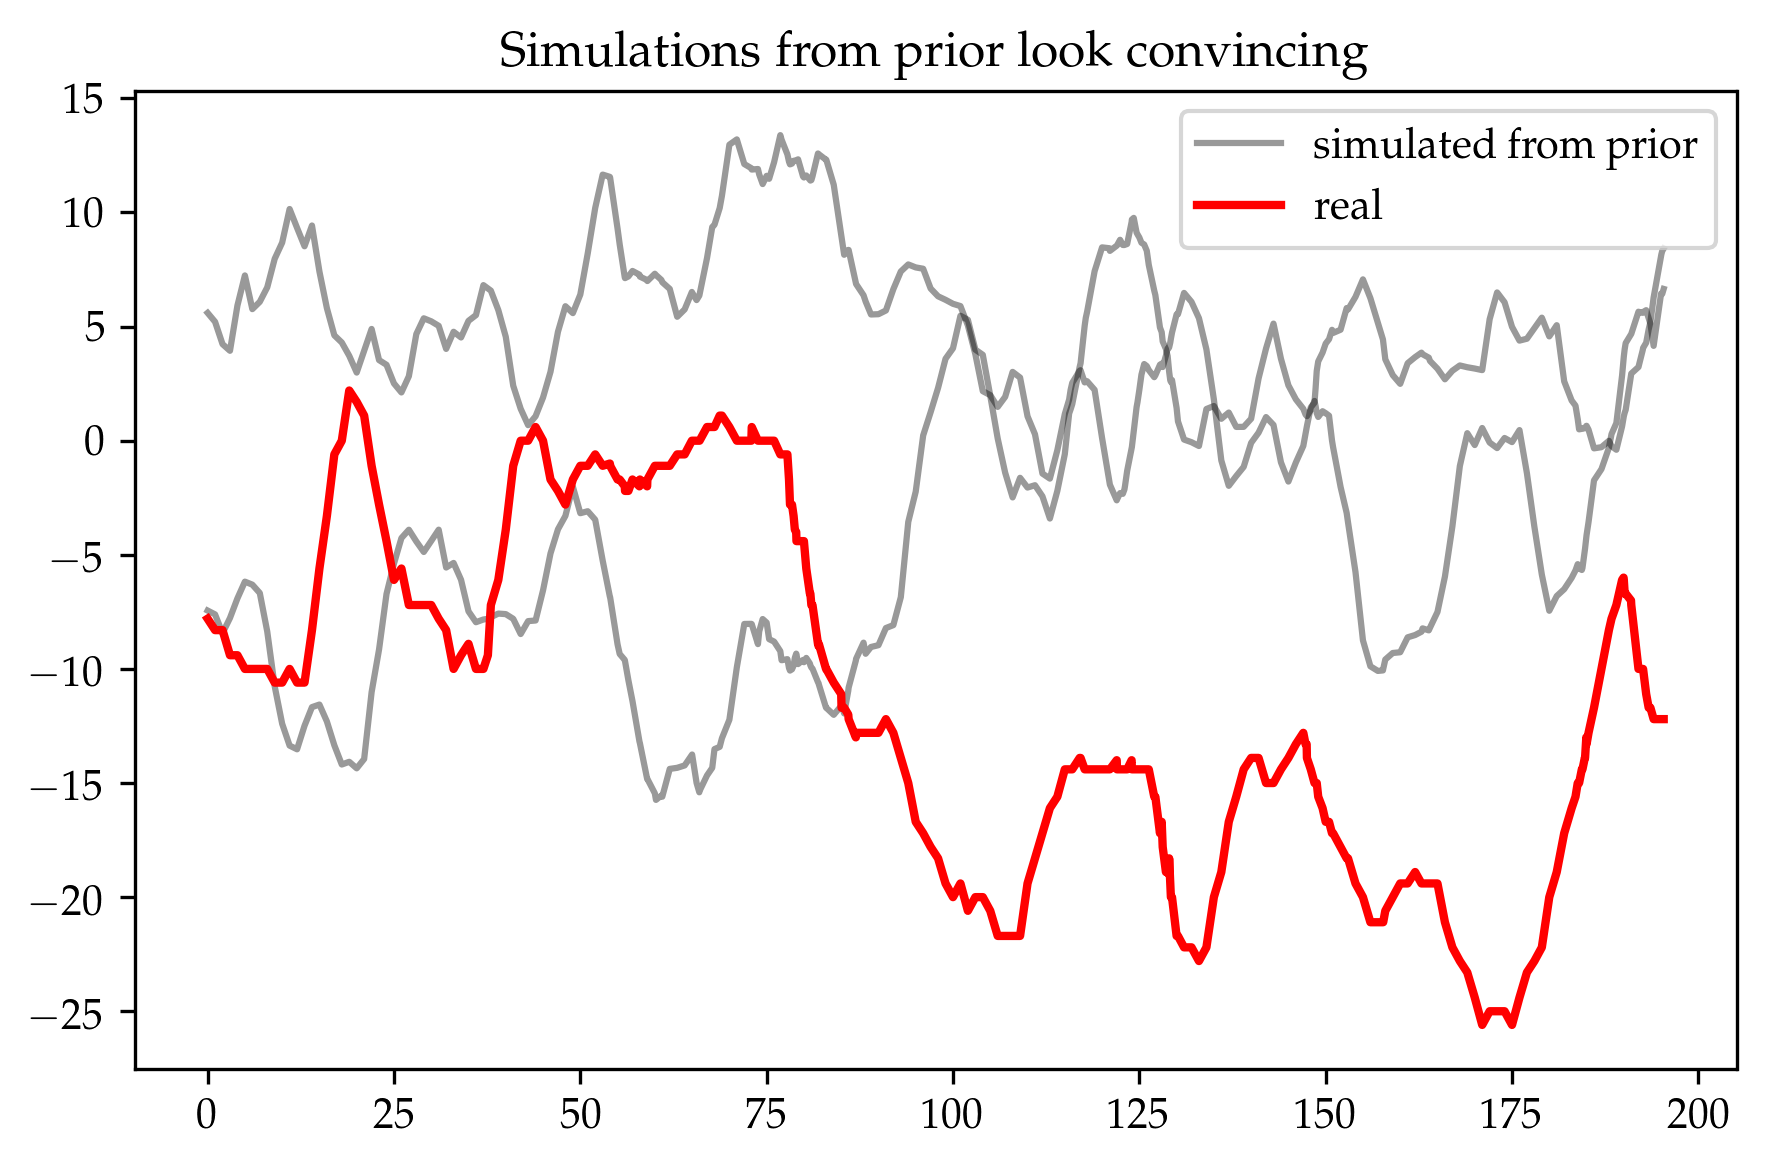

In [27]:
begin 
    gp_prior = GP(zeros(1,0), zeros(0), MeanConst(0.0), _k_nonoise, _gpr.logNoise)
    gp = _gpr.reals[1]
    x = gp.X
    plt.plot(vec(x), rand(gp_prior, x), color="black", alpha=0.4, label="simulated from prior")
    plt.plot(vec(x), rand(gp_prior, x), color="black", alpha=0.4)
    plt.plot(vec(x), gp.y, color="red", linewidth=2, label="real")
    plt.legend()
    plt.title("Simulations from prior look convincing")
end
;

## Variogram simulations

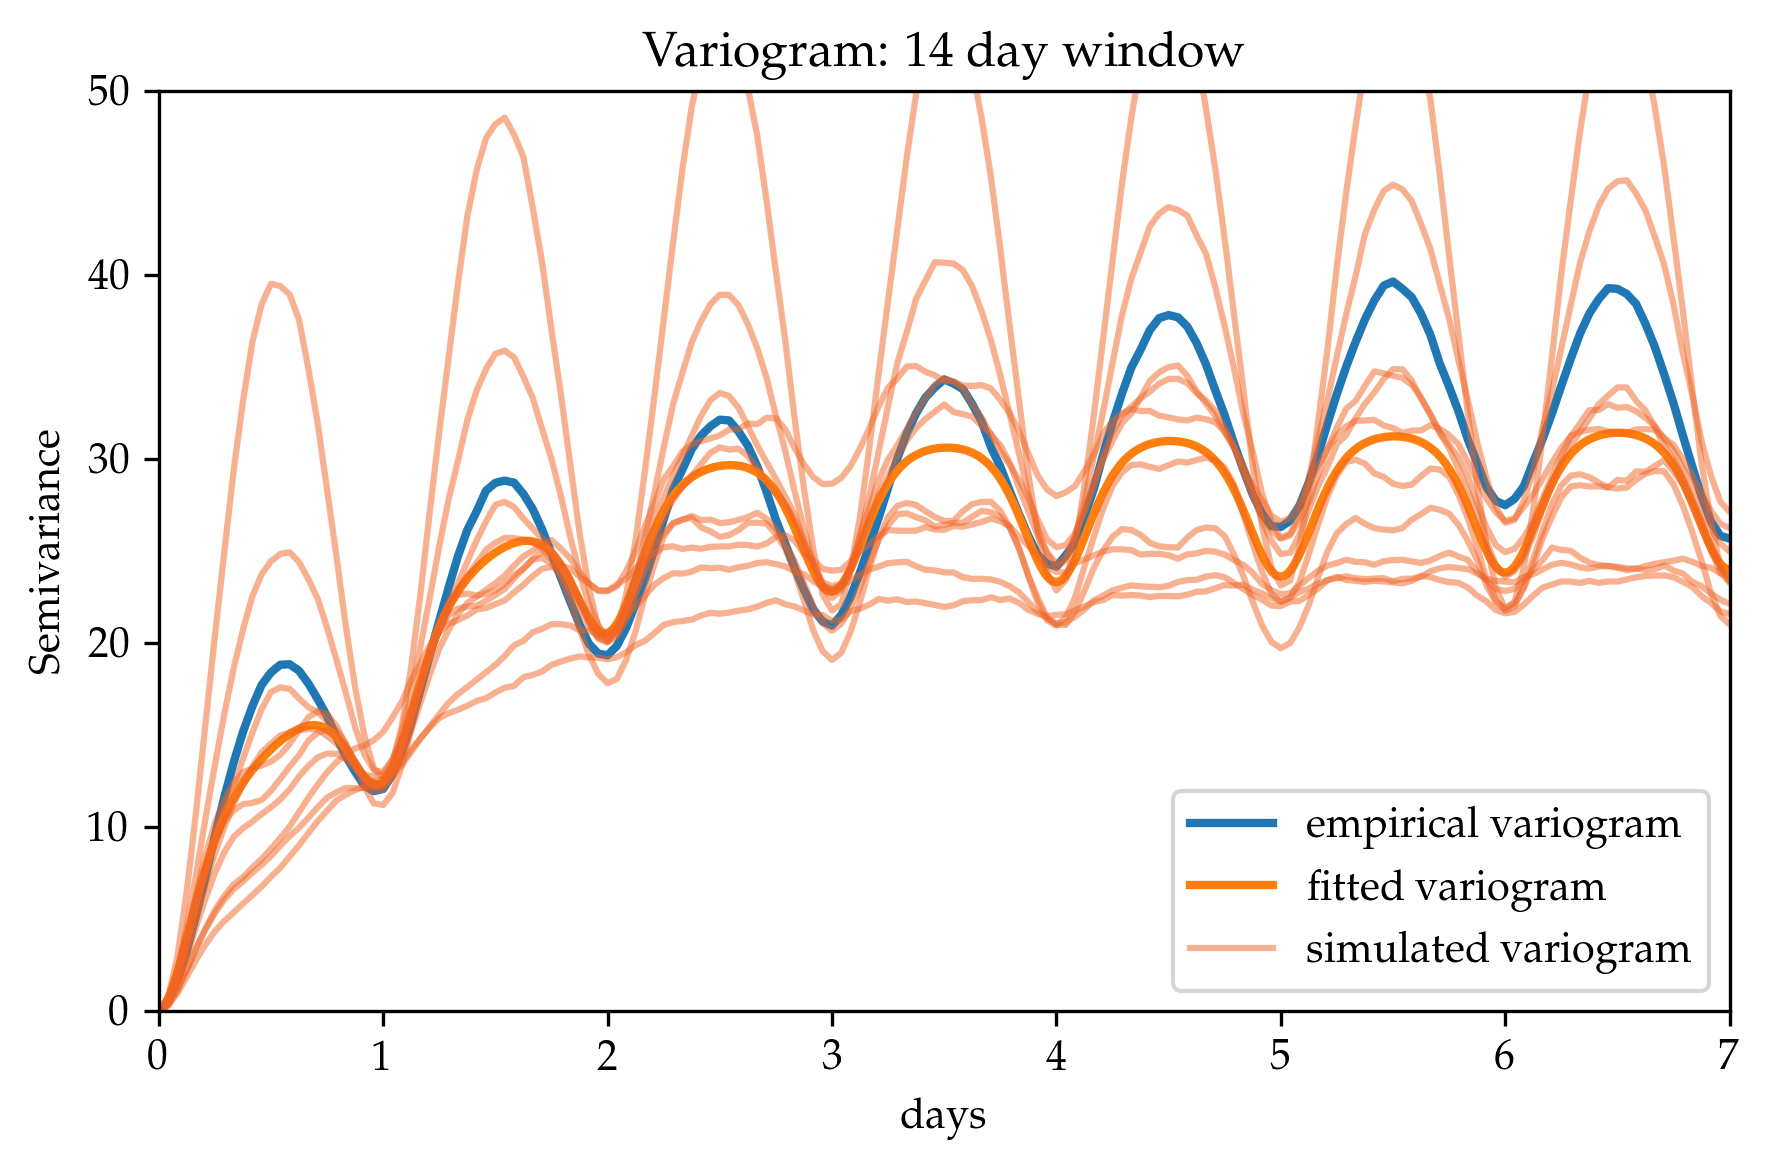

In [28]:
begin 
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, linewidth=2, label="empirical variogram")
    plt.ylim(0,50)
    plt.xlim(0,7)
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24.0, exp(2.0*_gpr.logNoise)+ck_r[1].-ck_r, linewidth=2, label="fitted variogram")
    
    for s in 1:10
        gp_prior = GP(zeros(1,0), zeros(0), MeanConst(0.0), _k_nonoise, _gpr.logNoise)
        simul1 = rand(gp_prior, ts_vec')
        simul_variog = variogram(ts_vec, simul1, _bins)
        label = s==1 ? "simulated variogram" : ""
        plt.plot(bins_days, simul_variog, color="#F16424", alpha=0.5, label=label)
    end
    plt.legend(loc="lower right")
    plt.xlabel("days")
    plt.ylabel("Semivariance")
    plt.title("Variogram: 14 day window")
end
;

# Understanding the periodic kernel

It looks to be like the periodic component's amplitude is too small in our fitted model. My intuition is that $\GP$s care more about fitting short-term correlations than long-term correlations (the opposite of a human fitting a variogram by eye). In the 24hr plot, it looks like the fitted variogram is overshooting its empirical counterpart slightly at $\Delta t= 2$ hours, and looking at the individual components of the fitted kernel, it's clear that this is driven by the period kernel. Therefore the fitted model might be choosing a reduced amplitude in order to reduce this discrepancy at low lags. What we want is a periodic kernel that is flatter at short lags. Let's explore our options.

In [29]:
# Reminder of the fitted periodic kernel
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.kern.σ2)
@printf("l: %5.3f\n", √k1.kern.ℓ2)
@printf("p: %5.0f hours\n", k1.kern.p)

k₁: Periodic 
σ: 2.889
l: 0.933
p:    24 hours


The periodic kernel I'm using here has three parameters ($\sigma$, $\l$ and $p$) and is defined as:
$$k(t,t') = \sigma^2 \exp\del{ - \frac{2}{\l^2} \sin^2(\pi (t-t') / p)}$$
Let's visually explore what the $\l$ parameter does.

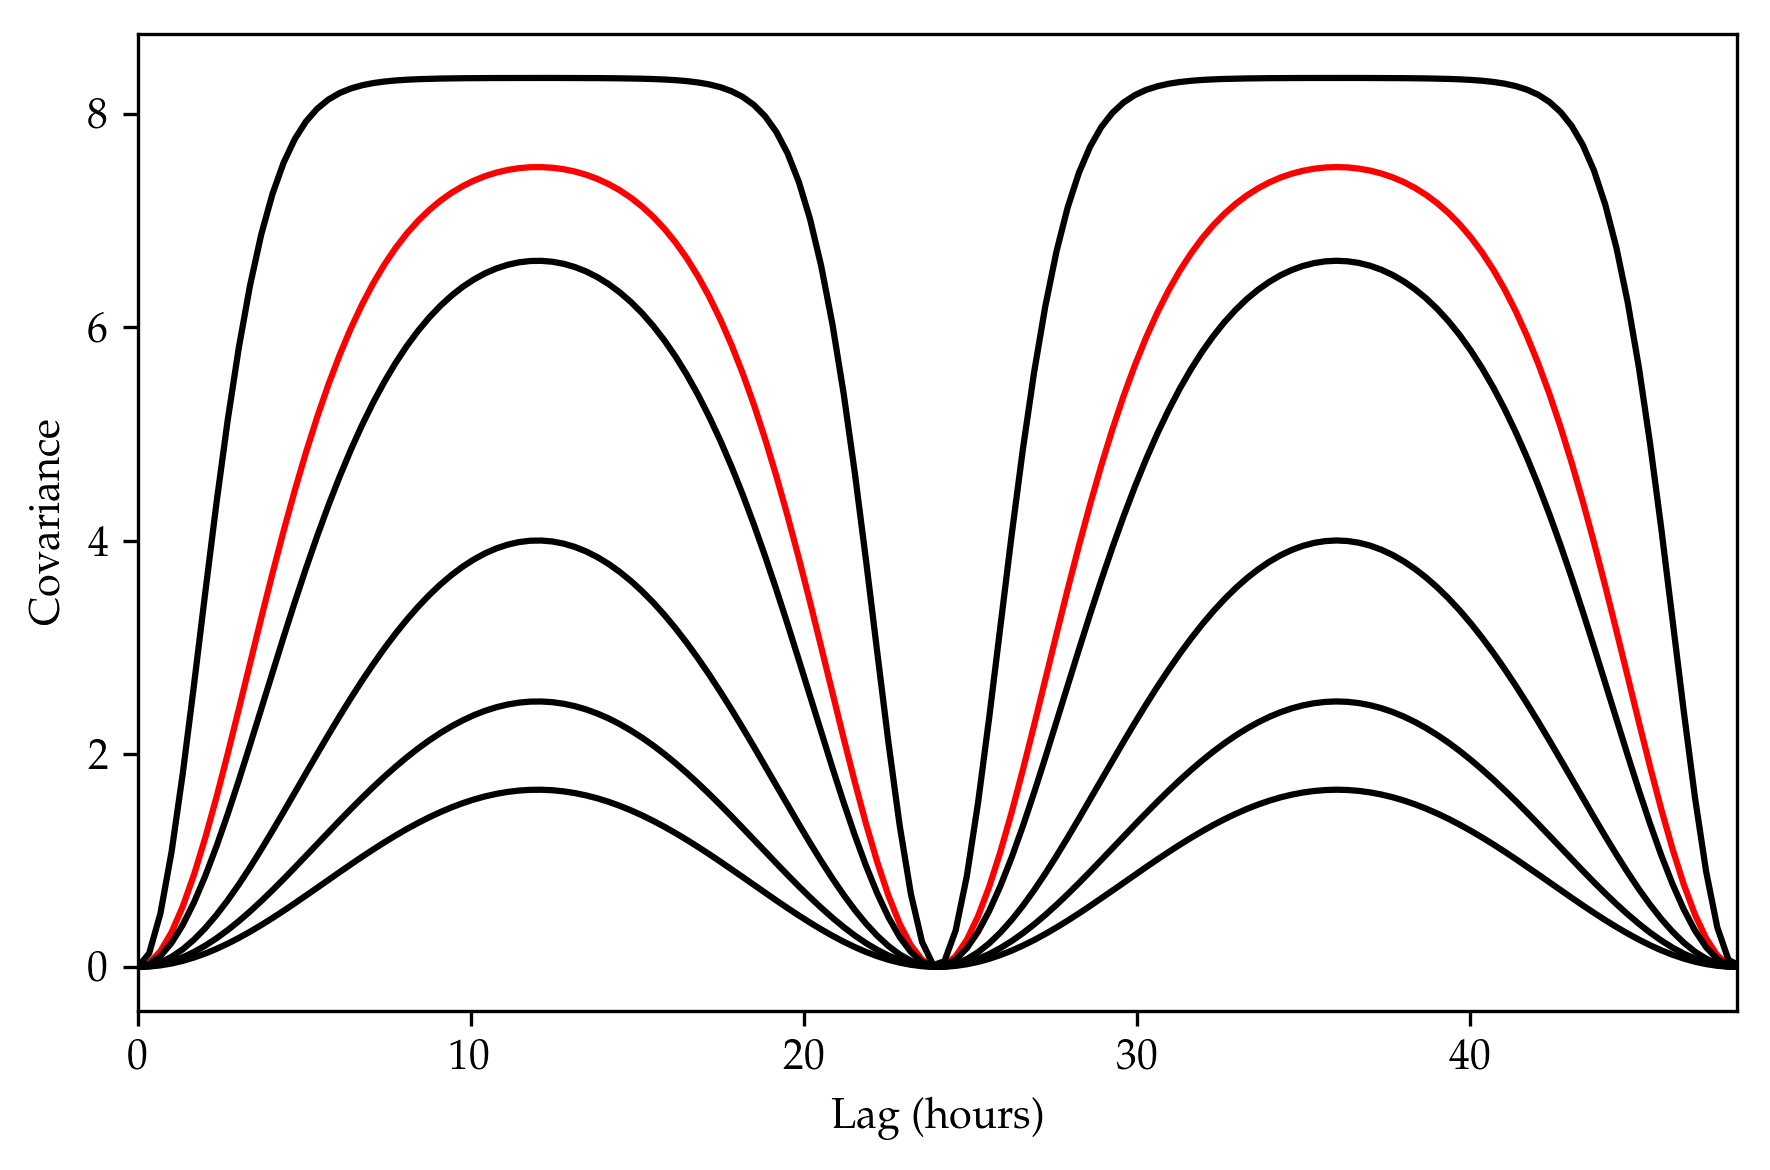

In [30]:
begin
    k1_free = GaussianProcesses.free(k1)
    cki_r = [cov(k1_free, [r], [0.0]) for r in rr]
    plt.plot(rr, cki_r[1]-cki_r, color="red")
    for 𝓁 in linspace(0.5,3.0,5)
        k = Periodic(log(𝓁), log(k1_free.σ2)/2.0, log(k1_free.p))
        cki_r = [cov(k, [r], [0.0]) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, color="black")
    end
end
plt.ylabel("Covariance")
plt.xlabel("Lag (hours)")
plt.xlim(0,24*2)
;

So, shorter $\l$ values correspond to a steeper rise in the variogram. But the effect is confusing because it also affects the amplitude of the kernel. Let's reparametrize the kernel and keep it constant.

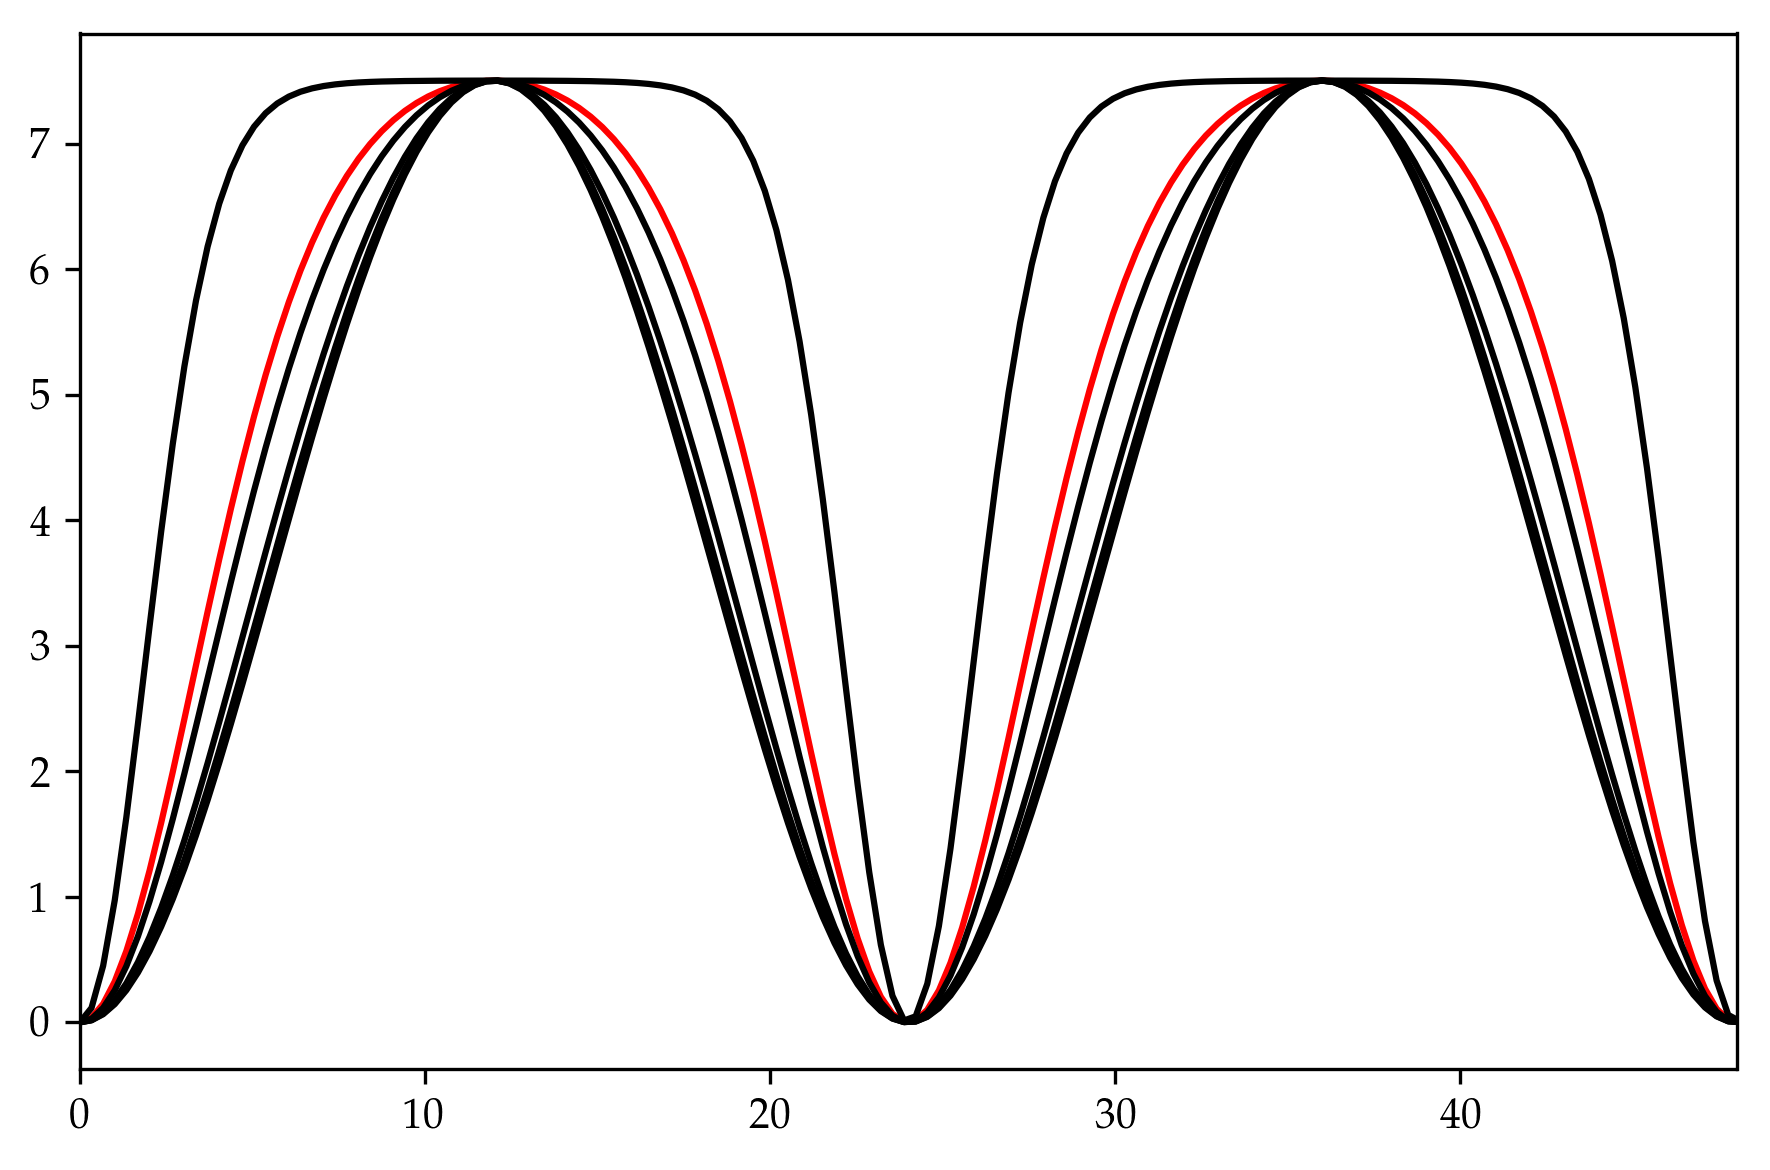

In [31]:
begin
    k1_free = GaussianProcesses.free(k1)
    rr = linspace(0.0, 24*14, 1000)
    cki_r = [cov(k1_free, [r], [0.0]) for r in rr]
    target_max = k1_free.σ2-cov(k1, [12.0], [0.0])
    plt.plot(rr, cki_r[1]-cki_r, color="red")
    for 𝓁 in linspace(0.5,3.0,5)
        k = Periodic(log(𝓁), 0.0, log(k1_free.p))
        max_ck = 1.0-cov(k, evaluate(metric(k), [12.0], [0.0]))
        k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, log(k1_free.p))
        cki_r = [cov(k_scaled, evaluate(metric(k_scaled), [r], [0.0])) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, color="black")
    end
    plt.xlim(0,24*2);
end
;

So we can adjust how steeply the kernel rises while keeping the amplitude constant. This is confusing because it seems like the optimization should therefore have chosen a kernel with a longer lengthscale and higher $\sigma^2$, to better fit the empirical variogram. Let's see if we can fit the empirical variogram, and check that the marginal likelihood goes down, to make sure it isn't the optimization failing.

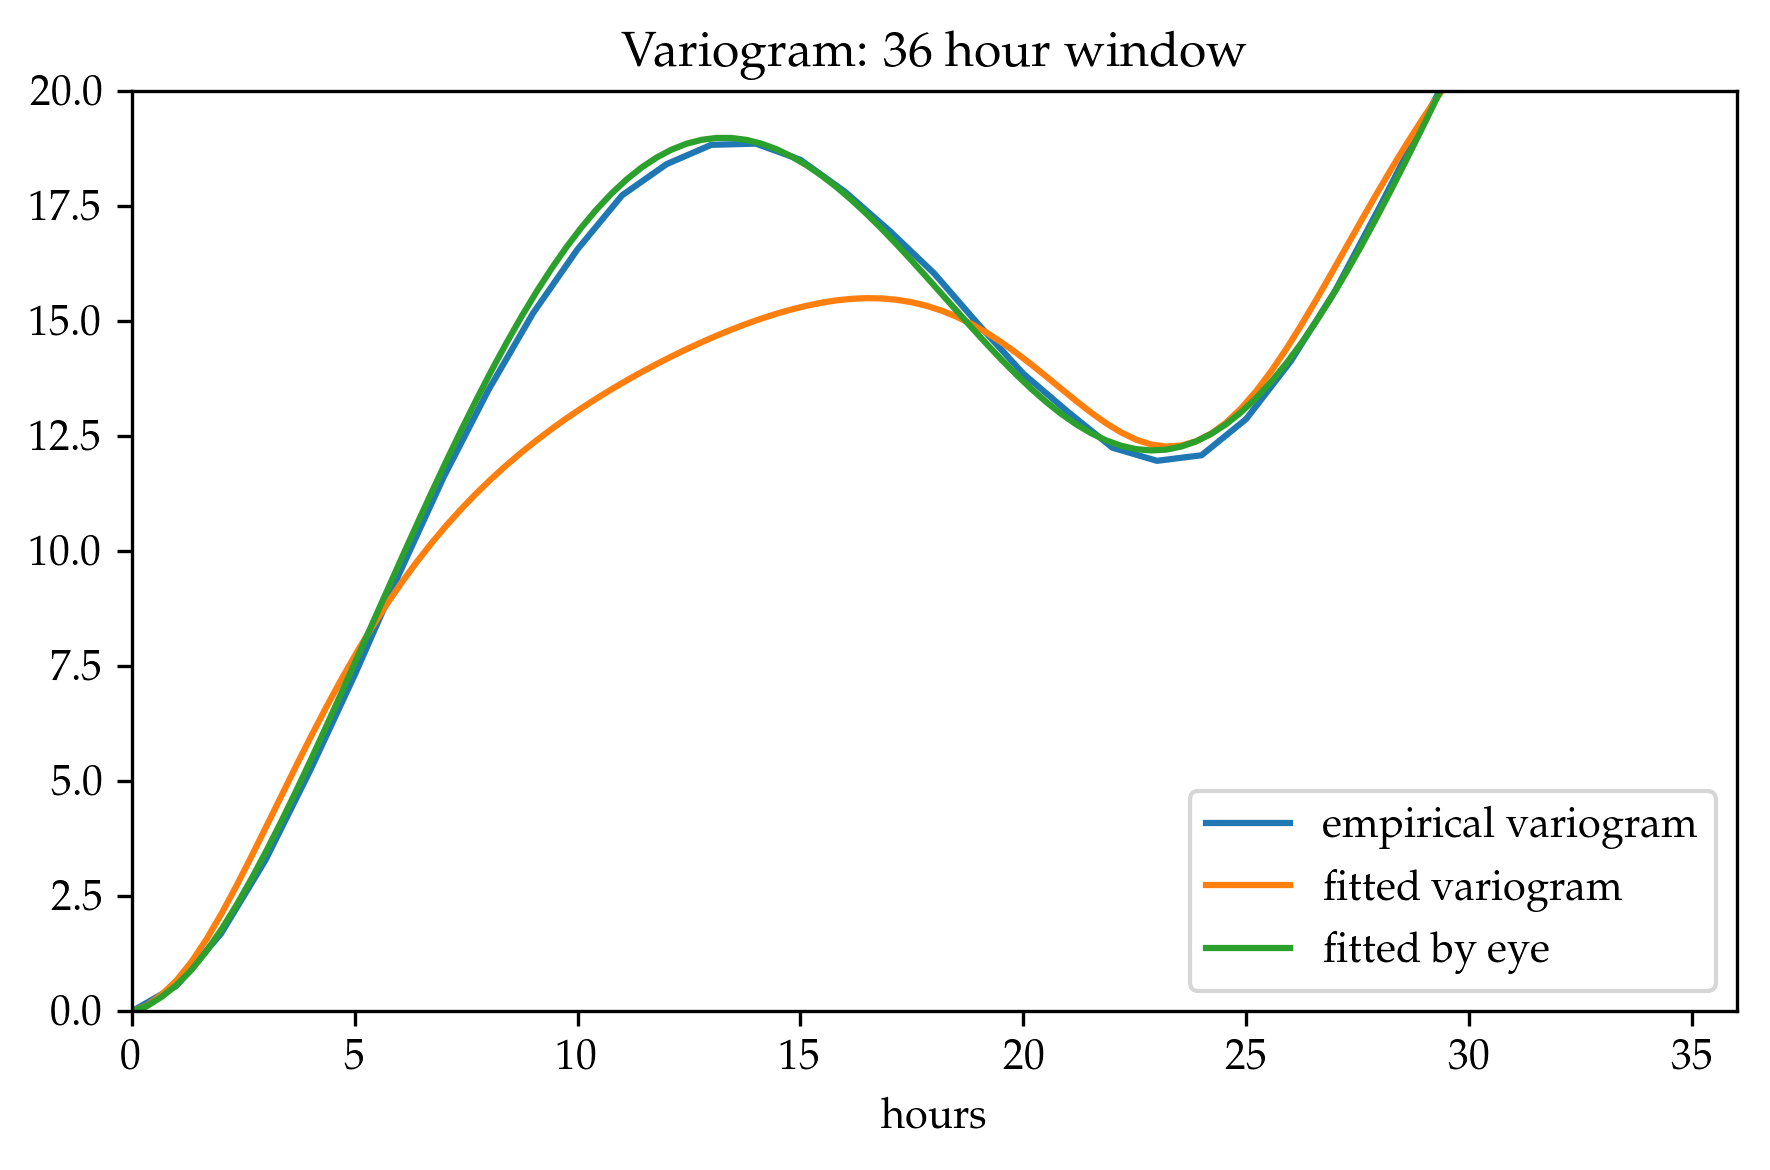

In [32]:
begin
    k1_free = GaussianProcesses.free(k1)
    lp = get_params(k1_free)[end]
    target_max = 12.0 # by eye
    rr = linspace(0.0, 24*14, 1000)
    𝓁 = 4.0
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    k = Periodic(log(𝓁), 0.0, lp)
    max_ck = 1.0-cov(k, [12.0], [0.0])
    k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, lp)
    my_sumkernel = k_scaled + k2 + k3 + k4 + k5 + k6
    plt.plot(bins_hours, station_variog, label="empirical variogram")
    rr = linspace(0.0, 24*14, 1000)
    ck_r_mine = [cov(my_sumkernel, r) for r in rr]
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr, ck_r[1].-ck_r, label="fitted variogram")
    plt.plot(rr, ck_r_mine[1].-ck_r_mine, label="fitted by eye")
    plt.legend(loc="lower right")
    plt.xlabel("hours")
    plt.ylim(0,20)
    plt.xlim(0,36)
    plt.title("Variogram: 36 hour window")
end
;

In [33]:
begin
    k1_free = GaussianProcesses.free(k1)
    lp = get_params(k1_free)[end]
    target_max = 12.0 # by eye
    𝓁 = 4.0
    k = Periodic(log(𝓁), 0.0, lp)
    max_ck = 1.0-cov(k, [12.0], [0.0])
    k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, lp)
    my_sumkernel = k_scaled + k2 + k3 + k4 + k5 + k6
    gprealisations=GPE[]
    istart=1
    while istart+chunksize < length(ts_arr)
        x = ts_arr[istart:istart+chunksize-1]
        y = temp_vec[istart:istart+chunksize-1]
        m = MeanConst(mean(y))
        gp = GP(x, y, m, my_sumkernel, _gpr.logNoise);
        push!(gprealisations, gp)
        istart+=chunksize
    end
    my_gpr = GPRealisations(gprealisations, _meanfunc, my_sumkernel, _gpr.logNoise, 0.0, Float64[])
    update_mll!(my_gpr)
    @printf("mLL unmodified: %.1f\n", my_gpr.mll)
    optimize!(my_gpr, noise=true, mean=false, kern=false, options=Optim.Options(x_tol=1e-5, f_tol=1e-10));
    @printf("mLL after optimizing logNoise: %.1f\n", my_gpr.mll)
    optimize!(my_gpr, noise=true, mean=false, kern=true, options=Optim.Options(x_tol=1e-5, f_tol=1e-10));
    @printf("mLL after optimizing kernel: %.1f\n", my_gpr.mll)
end
;

mLL unmodified: -12649.6
mLL after optimizing logNoise: -12649.2
mLL after optimizing kernel: -12454.0


In [34]:
# what we had before
Optim.minimum(opt_out)

12454.084229928525

OK so this is clearly not a good idea! I don't know why the log-likelihood degrades significantly with a kernel that fits the empirical variogram so much better! To summarize what we've seen:
* The periodic component of the kernel obtained by optimization of the marginal likelihood has a lower magnitude than what can be seen in the empirical variogram.
* At first I though maybe the periodic kernel isn't flexible enough to fit the corelation structure for measurements a small duration away from each other.
* But I was able to manually find parameters that fit the variogram much better.
* However, the kernel that fits the variogram better has a much worse marginal likelihood
* I don't know why this is the case.
* In spatial statistics, fitting the variogram is considered less good (statistically) than optimizing the marginal likelihood. Therefore, I prefer to trust the kernel obtained through likelihood optimization.

# Matern Kernel

In [35]:
_gpr.logNoise

-1.4695384853928064

In [36]:
mk1 = fix(Periodic(log(0.5), log(√(3.0)), log(24.0)), :lp)
mk2 = Mat32Iso(log(2.0), log(√3.0)) # short term Matern
mk3 = SEIso(log(2.0), log(√3.0)) # short term SE
mk4 = Mat32Iso(log(1.0*24), log(√10.0))
mk5 = RQIso(log(10.0*24), log(√10.0), 3.0)
mk=k0+mk1+mk2+mk3+mk4+mk5
mk_nonoise=mk1+mk2+mk3+mk4+mk5
mlogNoise=log(1.0)
;

In [37]:
chunksize=300
istart=1
mat_gprealisations=GPE[]
while istart+chunksize < length(ts_arr)
    x = ts_arr[istart:istart+chunksize-1]
    y = temp_vec[istart:istart+chunksize-1]
    m = MeanConst(mean(y))
    gp = GPE(x, y, m, mk_nonoise, mlogNoise);
    push!(mat_gprealisations, gp)
    istart+=chunksize
end

In [38]:
mat_gpr = GPRealisations(mat_gprealisations, MeanZero(), mk_nonoise, mlogNoise, 0.0, Float64[]);
update_mll!(mat_gpr)
mat_gpr.mll

-18268.517349619327

In [39]:
init_x = get_params(mat_gpr; mean=false)

12-element Array{Float64,1}:
  0.0     
 -0.693147
  0.549306
  0.693147
  0.549306
  0.693147
  0.549306
  3.17805 
  1.15129 
  5.48064 
  1.15129 
  3.0     

In [40]:
@time m_opt_out=optimize!(mat_gpr, mean=false, options=Optim.Options(x_tol=1e-5, f_tol=1e-10));

446.047850 seconds (1.59 M allocations: 16.879 GiB, 0.48% gc time)


In [41]:
m_opt_out

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,-0.6931471805599453, ...]
 * Minimizer: [-1.5588222609892006,-0.03053289944693379, ...]
 * Minimum: 1.238106e+04
 * Iterations: 322
 * Convergence: true
   * |x - x'| < 1.0e-05: false 
     |x - x'| = 4.79e-05 
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: true
     |f(x) - f(x')| / |f(x)| = 8.22e-11 
   * |g(x)| < 1.0e-08: false 
     |g(x)| = 3.64e-02 
   * stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 660
 * Gradient Calls: 344

In [42]:
Optim.minimizer(m_opt_out)

12-element Array{Float64,1}:
 -1.55882  
 -0.0305329
  1.06039  
 -1.44638  
 -1.24024  
  1.66499  
  0.756607 
  0.926343 
  0.0763395
  3.17135  
  1.44093  
  5.96886  

In [43]:
set_params!(mat_gpr, init_x; mean=false)
update_mll!(mat_gpr)
mat_gpr.mll

-18268.517349619327

In [44]:
Optim.minimum(opt_out)

12454.084229928525

In [45]:
@time minf,minx,ret,count = optimize_NLopt(mat_gpr; mean=false, method=:LD_LBFGS, x_tol=1e-5, f_tol=1e-10)

142.561488 seconds (560.26 k allocations: 5.453 GiB, 0.45% gc time)


(12385.127081231227, [-1.5563, -0.0368977, 1.06012, -1.38956, -1.19061, -0.0300269, -1.03743, 1.86563, 0.9376, 3.21125, 1.41512, 6.0], :FTOL_REACHED, 106)

In [46]:
mat_gpr.mll

-12385.127081231227